# Data Generation

Generating training, validation data and solving instances

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pathlib import Path
from utils.data import generate_vrp_instance, solve
from joblib import Parallel, delayed

sns.set_theme()

## Solution time vs solution quality

In [25]:
np.random.seed(42)

num_nodes = 20
num_instances = 20

instances = []

for i in range(num_instances):
    instance = generate_vrp_instance(num_nodes)
    instances.append(instance)

In [2]:
def solver_wrapper(*args, **kwargs):
    solution, _solver = solve(*args, **kwargs)

    if solution is None:
        return None

    return solution["total_distance"]

In [44]:
time_limits = np.linspace(1, 10, 5).astype(int)

results = []
for time_limit in time_limits:
    solutions = Parallel(n_jobs=-1)(
        delayed(solver_wrapper)(instance, time_limit=time_limit)
        for instance in instances
    )
    results.append((time_limit, solutions))

In [80]:
x = []
y = []
x_avg = []
y_avg = []

for time_limit, solutions in results:
    y_tmp = []

    for solution in solutions:
        if solution is not None:
            x.append(time_limit)
            y.append(solution)
            y_tmp.append(solution)

    x_avg.append(time_limit)
    y_avg.append(np.mean(y_tmp))

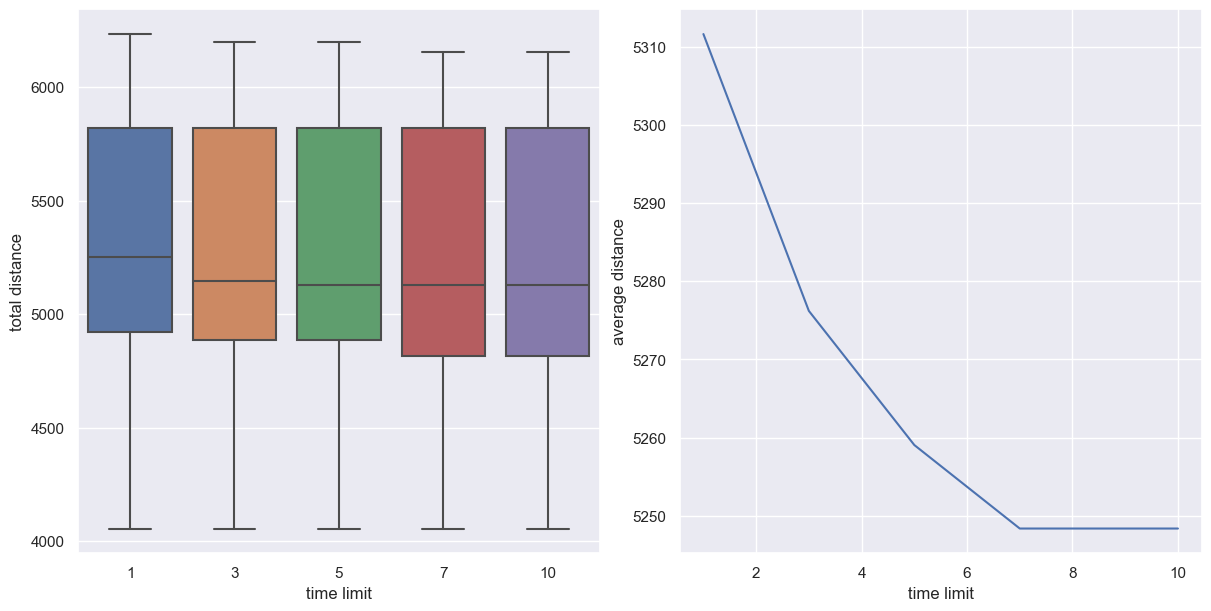

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), layout="constrained")

box = sns.boxplot(x=x, y=y, ax=ax1)
box.set_xlabel("time limit")
box.set_ylabel("total distance")

lin = sns.lineplot(x=x_avg, y=y_avg, ax=ax2)
lin.set_xlabel("time limit")
lin.set_ylabel("average distance")

plt.show()

In [93]:
arg = np.argmin(np.diff(y_avg) / y_avg[:-1]) + 1

print("Most increase in solution quality:", time_limits[arg], "seconds")

Most increase in solution quality: 3 seconds


Biggest increase in solution quality comes at 3 seconds, so we can use that for solving the instances.

## Create datasets

In [33]:
import torch

from collections import Counter
from utils.data import VRPData, load_pickle, get_errors, store_pickle

In [48]:
files = ("vrp_20_10000_3s.pkl", "vrp_20_10000_3s_part_1.pkl")

data = []
for file in files:
    try:
        data.extend(load_pickle(f"data/{file}"))
    except FileNotFoundError:
        pass

In [69]:
len(get_errors(data))

0

In [70]:
vehicles_used = [d["vehicles_used"] for d in data]
Counter(vehicles_used)

Counter({2: 940, 3: 18646, 4: 413, 5: 1})

In [52]:
filename = "data/vrp_20_rand_depot.pkl"

if len(data):
    store_pickle(data, filename)
else:
    data = load_pickle(filename)

In [87]:
dataset_normalized = VRPData.load(data, k=3, normalize_demand=True, test_size=0.01)
dataset_unnormalized = VRPData.load(data, k=3, normalize_demand=False, test_size=0.01)

In [89]:
torch.save(dataset_normalized, "data/vrp_20_k3_normalized.pt")
torch.save(dataset_unnormalized, "data/vrp_20_k3_unnormalized.pt")